The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Redes Neurais Convolucionais Profundas (AlexNet)
:label:`sec_alexnet`

Embora as CNNs fossem bem conhecidas
nas comunidades de visão computacional e aprendizado de máquina
após a introdução do LeNet,
eles não dominaram imediatamente o campo.
Embora LeNet tenha alcançado bons resultados em pequenos conjuntos de dados iniciais,
o desempenho e a viabilidade de treinamento de CNNs
em conjuntos de dados maiores e mais realistas ainda não foram estabelecidos.
Na verdade, durante grande parte do tempo intermediário entre o início da década de 1990
e os resultados do divisor de águas de 2012,
redes neurais muitas vezes eram superadas por outros métodos de aprendizado de máquina,
como máquinas de vetores de suporte.

Para a visão computacional, essa comparação talvez não seja justa.
Isso embora as entradas para redes convolucionais
consistam em valores de pixel brutos ou levemente processados (por exemplo, pela centralização), os profissionais nunca alimentariam pixels brutos em modelos tradicionais.
Em vez disso, pipelines típicos de visão computacional
consistiam em pipelines de extração de recursos de engenharia manual.
Em vez de *aprender os recursos*, os recursos foram *criados*.
A maior parte do progresso veio de ter ideias mais inteligentes para recursos,
e o algoritmo de aprendizagem foi frequentemente relegado a uma reflexão tardia.

Embora alguns aceleradores de rede neural estivessem disponíveis na década de 1990,
eles ainda não eram suficientemente poderosos para fazer
CNNs multicanal e multicamadas profundas
com um grande número de parâmetros.
Além disso, os conjuntos de dados ainda eram relativamente pequenos.
Somados a esses obstáculos, truques-chave para treinar redes neurais
incluindo heurísticas de inicialização de parâmetros,
variantes inteligentes de descida gradiente estocástica,
funções de ativação não esmagadoras,
e ainda faltavam técnicas de regularização eficazes.

Assim, em vez de treinar sistemas *ponta a ponta* (pixel para classificação),
pipelines clássicos pareciam mais com isto:

1. Obtenha um conjunto de dados interessante. No início, esses conjuntos de dados exigiam sensores caros (na época, as imagens de 1 megapixel eram de última geração).
1. Pré-processe o conjunto de dados com recursos feitos à mão com base em algum conhecimento de ótica, geometria, outras ferramentas analíticas e, ocasionalmente, nas descobertas fortuitas de alunos de pós-graduação sortudos.
1. Alimente os dados por meio de um conjunto padrão de extratores de recursos, como o SIFT (transformação de recurso invariante de escala) :cite:`Lowe.2004`, o SURF (recursos robustos acelerados) :cite:`Bay.Tuytelaars.Van- Gool.2006`, ou qualquer outro duto ajustado manualmente.
1. 1.espeje as representações resultantes em seu classificador favorito, provavelmente um modelo linear ou método de kernel, para treinar um classificador.

Se você conversasse com pesquisadores de aprendizado de máquina,
eles acreditavam que o aprendizado de máquina era importante e bonito.
Teorias elegantes provaram as propriedades de vários classificadores.
O campo do aprendizado de máquina era próspero, rigoroso e eminentemente útil. No entanto, se você falou com um pesquisador de visão computacional,
você ouviria uma história muito diferente.
A verdade suja do reconhecimento de imagem, eles diriam a você,
é que os recursos, e não os algoritmos de aprendizagem, impulsionaram o progresso.
Pesquisadores de visão computacional acreditavam com razão
que um conjunto de dados ligeiramente maior ou mais limpo
ou um pipeline de extração de recursos ligeiramente melhorado
importava muito mais para a precisão final do que qualquer algoritmo de aprendizado.

## Representaçao do Aprendizado

Outra forma de definir o estado de coisas é que
a parte mais importante do pipeline foi a representação.
E até 2012 a representação era calculada mecanicamente.
Na verdade, desenvolver um novo conjunto de funções de recursos, melhorar os resultados e escrever o método era um gênero de papel proeminente.
SIFT :cite:`Lowe.2004`,
SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`,
HOG (histogramas de gradiente orientado) :cite: `Dalal.Triggs.2005`,
[pacotes de palavras visuais](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)
e extratores de recursos semelhantes são os mais usados.

Outro grupo de pesquisadores,
incluindo Yann LeCun, Geoff Hinton, Yoshua Bengio,
Andrew Ng, Shun-ichi Amari e Juergen Schmidhuber,
tinha planos diferentes.
Eles acreditavam que as próprias características deveriam ser aprendidas.
Além disso, eles acreditavam que era razoavelmente complexo,
os recursos devem ser compostos hierarquicamente
com várias camadas aprendidas em conjunto, cada uma com parâmetros aprendíveis.
No caso de uma imagem, as camadas mais baixas podem vir
para detectar bordas, cores e texturas.
De fato,
Alex Krizhevsky, Ilya Sutskever e Geoff Hinton
propôs uma nova variante de uma CNN,
*AlexNet*,
que obteve excelente desempenho no desafio ImageNet de 2012.
AlexNet foi nomeado após Alex Krizhevsky,
o primeiro autor do inovador artigo de classificação ImageNet :cite:`Krizhevsky.Sutskever.Hinton.2012`.

Curiosamente, nas camadas mais baixas da rede,
o modelo aprendeu extratores de recursos que se assemelhavam a alguns filtros tradicionais.
:numref:`fig_filters` é reproduzido do artigo AlexNet :cite:`Krizhevsky.Sutskever.Hinton.2012`
e descreve descritores de imagem de nível inferior.

![Filtros de imagem aprendidos pela primeira camada do AlexNet.](../img/filters.png)
:width:`400px`
:label:`fig_filters`

As camadas superiores da rede podem se basear nessas representações
para representar estruturas maiores, como olhos, narizes, folhas de grama e assim por diante.
Mesmo camadas mais altas podem representar objetos inteiros
como pessoas, aviões, cães ou frisbees.
Em última análise, o estado oculto final aprende uma representação compacta
da imagem que resume seu conteúdo
de forma que os dados pertencentes a diferentes categorias possam ser facilmente separados.

Enquanto a inovação definitiva para CNNs de várias camadas
veio em 2012, um grupo central de pesquisadores se dedicou
a esta ideia, tentando aprender representações hierárquicas de dados visuais
por muitos anos.
O grande avanço em 2012 pode ser atribuído a dois fatores principais.

### Ingrediente Faltante: Dados

Modelos profundos com muitas camadas requerem grandes quantidades de dados
a fim de entrar no regime
onde superam significativamente os métodos tradicionais
com base em otimizações convexas (por exemplo, métodos lineares e de kernel).
No entanto, dada a capacidade limitada de armazenamento dos computadores,
a despesa relativa de sensores,
e os orçamentos de pesquisa comparativamente mais apertados na década de 1990,
a maioria das pesquisas baseou-se em pequenos conjuntos de dados.
Numerosos artigos abordaram a coleção de conjuntos de dados da UCI,
muitos dos quais continham apenas centenas ou (alguns) milhares de imagens
capturado em configurações não naturais com baixa resolução.

Em 2009, o conjunto de dados ImageNet foi lançado,
desafiando os pesquisadores a aprender modelos a partir de 1 milhão de exemplos,
1000 categorias distintas de objetos com 1000 dados em cada.
Os pesquisadores, liderados por Fei-Fei Li, que apresentou este conjunto de dados
aproveitou a Pesquisa de imagens do Google para pré-filtrar grandes conjuntos de candidatos
para cada categoria e empregado
o pipeline de crowdsourcing Amazon Mechanical Turk
para confirmar para cada imagem se pertencia à categoria associada.
Essa escala não tinha precedentes.
A competição associada, apelidada de Desafio ImageNet
impulsionou a pesquisa sobre visão computacional e aprendizado de máquina,
desafiando os pesquisadores a identificar quais modelos tiveram melhor desempenho
em uma escala maior do que os acadêmicos haviam considerado anteriormente.

### Ingrediente Faltante: *Hardware*

Modelos de aprendizado profundo são consumidores vorazes de ciclos de computação.
O treinamento pode levar centenas de épocas, e cada iteração
requer a passagem de dados por muitas camadas de operações de álgebra linear de alto custo computacional.
Esta é uma das principais razões pelas quais, na década de 1990 e no início de 2000,
algoritmos simples baseados em algoritmos otimizados de objetivas convexas mais eficientes
 foram preferidas. 

*Unidades de processamento gráfico* (GPUs) provaram ser uma virada de jogo
para tornar o aprendizado profundo viável.
Esses chips há muito foram desenvolvidos para acelerar
processamento gráfico para beneficiar os jogos de computador.
Em particular, eles foram otimizados para produtos de vetor de matriz de alta capacidade $4 \times 4$, que são necessários para muitas tarefas de computação gráfica.
Felizmente, essa matemática é muito semelhante
ao necessário para calcular camadas convolucionais.
Naquela época, a NVIDIA e a ATI começaram a otimizar GPUs
para operações gerais de computação,
indo tão longe a ponto de comercializá-los como *GPUs de uso geral* (GPGPU).

Para fornecer alguma intuição, considere os núcleos de um microprocessador moderno
(CPU).
Cada um dos núcleos é bastante poderoso rodando em uma alta frequência de clock
e exibindo grandes caches (até vários megabytes de L3).
Cada núcleo é adequado para executar uma ampla gama de instruções,
com preditores de ramificação, um pipeline profundo e outras técnicas
que permitem executar uma grande variedade de programas.
Essa aparente força, no entanto, é também seu calcanhar de Aquiles:
núcleos de uso geral são muito caros para construir.
Eles exigem muita área de chip,
uma estrutura de suporte sofisticada
(interfaces de memória, lógica de cache entre os núcleos,
interconexões de alta velocidade e assim por diante),
e são comparativamente ruins em qualquer tarefa.
Laptops modernos têm até 4 núcleos,
e até mesmo servidores de última geração raramente excedem 64 núcleos,
simplesmente porque não é rentável.

Em comparação, as GPUs consistem em $100 \sim 1000$ pequenos elementos de processamento
(os detalhes diferem um pouco entre NVIDIA, ATI, ARM e outros fornecedores de chips),
frequentemente agrupados em grupos maiores (a NVIDIA os chama de warps).
Embora cada núcleo seja relativamente fraco,
às vezes até rodando em frequência de clock abaixo de 1 GHz,
é o número total de tais núcleos que torna as GPUs ordens de magnitude mais rápidas do que as CPUs.
Por exemplo, a recente geração Volta da NVIDIA oferece até 120 TFlops por chip para instruções especializadas
(e até 24 TFlops para aqueles de uso geral),
enquanto o desempenho de ponto flutuante de CPUs não excedeu 1 TFlop até o momento.
A razão pela qual isso é possível é bastante simples:
primeiro, o consumo de energia tende a crescer *quadraticamente* com a frequência do clock.
Portanto, para o orçamento de energia de um núcleo da CPU que funciona 4 vezes mais rápido (um número típico),
você pode usar 16 núcleos de GPU por $1/4$ a velocidade,
que rende $16 \times 1/4 = 4$ vezes o desempenho.
Além disso, os núcleos da GPU são muito mais simples
(na verdade, por muito tempo eles nem mesmo foram *capazes*
para executar código de uso geral),
o que os torna mais eficientes em termos de energia.
Por último, muitas operações de aprendizado profundo exigem alta largura de banda de memória.
Novamente, as GPUs brilham aqui com barramentos que são pelo menos 10 vezes mais largos que muitas CPUs.

De volta a 2012. Um grande avanço veio
quando Alex Krizhevsky e Ilya Sutskever
implementou uma CNN profunda
que pode ser executado em hardware GPU.
Eles perceberam que os gargalos computacionais nas CNNs,
convoluções e multiplicações de matrizes,
são todas as operações que podem ser paralelizadas no hardware.
Usando dois NVIDIA GTX 580s com 3 GB de memória,
eles implementaram convoluções rápidas.
O código [cuda-convnet](https://code.google.com/archive/p/cuda-convnet/)
foi bom o suficiente por vários anos,
era o padrão da indústria e alimentou
os primeiros anos do boom do aprendizado profundo.

## AlexNet

AlexNet, que empregava uma CNN de 8 camadas,
venceu o Desafio de Reconhecimento Visual em Grande Escala ImageNet 2012
por uma margem fenomenalmente grande.
Esta rede mostrou, pela primeira vez,
que os recursos obtidos pelo aprendizado podem transcender recursos projetados manualmente, quebrando o paradigma anterior em visão computacional.

As arquiteturas de AlexNet e LeNet são muito semelhantes,
como :numref:`fig_alexnet` ilustra.
Observe que fornecemos uma versão ligeiramente simplificada do AlexNet
removendo algumas das peculiaridades de design que eram necessárias em 2012
para fazer o modelo caber em duas pequenas GPUs.

![De LeNet (esquerda) para AlexNet (direita).](http://d2l.ai/_images/alexnet.svg)
:label:`fig_alexnet`

As filosofias de design de AlexNet e LeNet são muito semelhantes,
mas também existem diferenças significativas.
Primeiro, o AlexNet é muito mais profundo do que o comparativamente pequeno LeNet5.
AlexNet consiste em oito camadas: cinco camadas convolucionais,
duas camadas ocultas totalmente conectadas e uma camada de saída totalmente conectada. Em segundo lugar, AlexNet usou o ReLU em vez do sigmóide
como sua função de ativação.
Vamos nos aprofundar nos detalhes abaixo.

### Arquitetura

Na primeira camada do AlexNet, a forma da janela de convolução é $11 \times 11$.
Uma vez que a maioria das imagens no ImageNet são mais de dez vezes maiores e mais largas
do que as imagens MNIST,
objetos em dados ImageNet tendem a ocupar mais pixels.
Consequentemente, uma janela de convolução maior é necessária para capturar o objeto.
A forma da janela de convolução na segunda camada
é reduzido para $5 \times 5$, seguido por $3 \times 3$.
Além disso, após a primeira, segunda e quinta camadas convolucionais,
a rede adiciona camadas de pooling máximas
com um formato de janela de $3 \times 3$ e uma distância de 2.
Além disso, o AlexNet tem dez vezes mais canais de convolução do que o LeNet.

Após a última camada convolucional, existem duas camadas totalmente conectadas
com 4096 saídas.
Essas duas enormes camadas totalmente conectadas produzem parâmetros de modelo de quase 1 GB.
Devido à memória limitada nas primeiras GPUs,
o AlexNet original usava um design de fluxo de dados duplo,
para que cada uma de suas duas GPUs pudesse ser responsável
para armazenar e computar apenas sua metade do modelo.
Felizmente, a memória da GPU é comparativamente abundante agora,
então raramente precisamos separar os modelos das GPUs hoje em dia
(nossa versão do modelo AlexNet se desvia
do artigo original neste aspecto).

### Função de Ativação

Além disso, AlexNet mudou a função de ativação sigmóide para uma função de ativação ReLU mais simples. Por um lado, o cálculo da função de ativação ReLU é mais simples. Por exemplo, ele não tem a operação de exponenciação encontrada na função de ativação sigmóide.
  Por outro lado, a função de ativação ReLU torna o treinamento do modelo mais fácil ao usar diferentes métodos de inicialização de parâmetro. Isso ocorre porque, quando a saída da função de ativação sigmóide está muito próxima de 0 ou 1, o gradiente dessas regiões é quase 0, de modo que a retropropagação não pode continuar a atualizar alguns dos parâmetros do modelo. Em contraste, o gradiente da função de ativação ReLU no intervalo positivo é sempre 1. Portanto, se os parâmetros do modelo não forem inicializados corretamente, a função sigmóide pode obter um gradiente de quase 0 no intervalo positivo, de modo que o modelo não pode ser efetivamente treinados.

### Controle de Capacidade e Pré-processamento

AlexNet controla a complexidade do modelo da camada totalmente conectada
por *dropout* (:numref:`sec_dropout`),
enquanto o LeNet usa apenas redução de peso.
Para aumentar ainda mais os dados, o loop de treinamento do AlexNet
adicionou uma grande quantidade de aumento de imagem,
como inversão, recorte e alterações de cor.
Isso torna o modelo mais robusto e o tamanho de amostra maior reduz efetivamente o sobreajuste.
Discutiremos o aumento de dados em maiores detalhes em :numref:`sec_image_augmentation`.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # Aqui, usamos uma janela maior de 11 x 11 para capturar objetos. Ao mesmo tempo,
    # usamos um passo de 4 para reduzir significativamente a altura e a largura
    # da saída. Aqui, o número de canais de saída
    # é muito maior do que no LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Torne a janela de convolução menor, defina o preenchimento para 2
    # para altura e largura consistentes na entrada e saída,
    # e aumente o número de canais de saída
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use três camadas convolucionais sucessivas e uma janela de convolução menor.
    # Exceto para a camada convolucional final, o número de canais de saída
    # é aumentado ainda mais. Camadas de pooling não são usadas para reduzir
    # a altura e largura de entrada após as duas primeiras camadas convolucionais
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Aqui, o número de saídas da camada totalmente conectada é várias
    # vezes maior do que no LeNet.
    # Use a camada de eliminação para mitigar overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Camada de saída. Como estamos usando o Fashion-MNIST,
    # o número de classes é 10, em vez de 1000 como no papel
    nn.Linear(4096, 10))

Construímos um exemplo de dados de canal único com altura e largura de 224 para observar a forma de saída de cada camada. Ele corresponde à arquitetura AlexNet em :numref:`fig_alexnet`.


In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## Lendo o Dataset

Embora AlexNet seja treinado em ImageNet no jornal, usamos Fashion-MNIST aqui
já que treinar um modelo ImageNet para convergência pode levar horas ou dias
mesmo em uma GPU moderna.
Um dos problemas de aplicar AlexNet diretamente no Fashion-MNIST
é que suas imagens têm resolução inferior ($28 \times 28$ pixels)
do que imagens ImageNet.
Para fazer as coisas funcionarem, aumentamos a amostra para $224 \times 224$
(geralmente não é uma prática inteligente,
mas fazemos isso aqui para sermos fiéis à arquitetura AlexNet).
Realizamos esse redimensionamento com o argumento `resize` na função` d2l.load_data_fashion_mnist`.


In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

## Treinamento

Agora, podemos começar a treinar AlexNet.
Comparado com LeNet em :numref:`sec_lenet`,
a principal mudança aqui é o uso de uma taxa de aprendizado menor
e um treinamento muito mais lento devido à rede mais ampla e profunda,
a resolução de imagem mais alta e as convoluções mais caras.


loss 0.330, train acc 0.879, test acc 0.881
4138.2 examples/sec on cuda:0


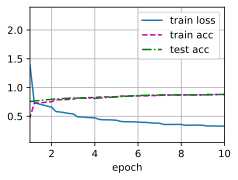

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Sumário

* AlexNet tem uma estrutura semelhante à do LeNet, mas usa mais camadas convolucionais e um espaço de parâmetro maior para caber no conjunto de dados ImageNet em grande escala.
* Hoje o AlexNet foi superado por arquiteturas muito mais eficazes, mas é um passo importante das redes superficiais para as profundas que são usadas hoje em dia.
* Embora pareça que existam apenas mais algumas linhas na implementação do AlexNet do que no LeNet, a comunidade acadêmica levou muitos anos para abraçar essa mudança conceitual e tirar proveito de seus excelentes resultados experimentais. Isso também se deveu à falta de ferramentas computacionais eficientes.
* Desistência, ReLU e pré-processamento foram as outras etapas importantes para alcançar um desempenho excelente em tarefas de visão computacional.

## Exercício

1. Experimente aumentar o número de épocas. Comparado com o LeNet, como os resultados são diferentes? Porque?
1. AlexNet pode ser muito complexo para o conjunto de dados Fashion-MNIST.
     1. Tente simplificar o modelo para tornar o treinamento mais rápido, garantindo que a precisão não caia significativamente.
     1. Projete um modelo melhor que funcione diretamente em imagens de $28 \times 28$.
1. Modifique o tamanho do lote e observe as mudanças na precisão e na memória da GPU.
1. Analise o desempenho computacional do AlexNet.
     1. Qual é a parte dominante para a pegada de memória do AlexNet?
     1. Qual é a parte dominante para computação no AlexNet?
     1. E quanto à largura de banda da memória ao calcular os resultados?
1. Aplique dropout e ReLU ao LeNet-5. Isso melhora? Que tal pré-processamento?


[Discussão](https://discuss.d2l.ai/t/76)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTg0MjIzODQxMywxODg5NDY0MDAyLDIwNz
UxNzc5MjYsMTQ1NjcwODQ4NCwxMzMxMzM5NDg3LDU1Njg1NDU5
NCwyNjcwOTA5MzQsMzQ0NjgzMjkzLC0xODg4NjE3MjQ5LC0zND
cwMTI4NjEsLTE5ODY1Mzg2NDcsLTE3MDQyMDg5NjldfQ==
-->
